In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import radius_neighbors_graph

import pySTIM as pst

import warnings
warnings.filterwarnings('ignore')
cmap = mcolors.LinearSegmentedColormap.from_list('WhRd',['#ffffff', "#fffacd", "red", "darkred"], N=256)  

In [2]:
adata_xe = sc.read_h5ad("../Xenium_all.h5ad")

In [3]:
ad = adata_xe[adata_xe.obs.ident == "Day14R"].copy()

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import radius_neighbors_graph
from sklearn.utils import resample
from joblib import Parallel, delayed
from tqdm import tqdm
import anndata

def calculate_colocalization2(adata: anndata.AnnData, 
							target_cell_type: str, 
							center_cell_type: str, 
							cluster_key: str = "celltype",
							spatial_key: str = "spatial",
							radius: int = 200, 
							grid_size: int = 800, 
							n_bootstrap: int = 1000, 
							confidence_level: float = 0.95, 
							n_jobs: int = -1) -> dict:
	
	spatial_data = pd.DataFrame({
		'x': adata.obsm[spatial_key][:, 0],
		'y': adata.obsm[spatial_key][:, 1],
		'cell_type': adata.obs[cluster_key]
	})
	
	def calculate_intensity(sub_data):
		if sub_data.empty:
			return 0
		
		cell_types = sub_data['cell_type']
		spatial_data = sub_data[['x', 'y']].values
		
		con = radius_neighbors_graph(spatial_data, radius, mode='connectivity', include_self=False)
		
		ref_indices = np.where(cell_types == center_cell_type)[0]
		sp_con = con[ref_indices, :].copy()
		sp_con.data[sp_con.data > 0] = 1  
		
		target_indices = np.where(cell_types == target_cell_type)[0]
		percentages = []
		
		for k in range(sp_con.shape[0]):
			sum_row = sp_con[k, :].sum()
			if sum_row == 0:
				continue
			self_indices = ref_indices  # Indices of center cells
			self_sum = sp_con[k, self_indices].sum()
			sum_row_update = sum_row - self_sum
			
			target_sum = sp_con[k, target_indices].sum()
			if sum_row_update != 0:
				percentage = (target_sum / sum_row_update) * 100
				percentages.append(percentage)
				
		return np.mean(percentages) if percentages else 0
	
	x_min, x_max = spatial_data['x'].min(), spatial_data['x'].max()
	y_min, y_max = spatial_data['y'].min(), spatial_data['y'].max()
	
	# Create grid
	x_bins = np.arange(x_min, x_max, grid_size)
	y_bins = np.arange(y_min, y_max, grid_size)
	
	grid = [(x_start, y_start) for x_start in x_bins for y_start in y_bins]
	
	def process_grid(x_start, y_start):
		sub_data = spatial_data[(spatial_data['x'] >= x_start) & (spatial_data['x'] < x_start + grid_size) &
								(spatial_data['y'] >= y_start) & (spatial_data['y'] < y_start + grid_size)]
		return calculate_intensity(sub_data)
	
	intensities = Parallel(n_jobs=n_jobs)(delayed(process_grid)(x_start, y_start) for x_start, y_start in grid)
	
	mean_intensity = np.mean(intensities)
	
	# Bootstrap for confidence intervals
	bootstrap_samples = [np.mean(resample(intensities)) for _ in range(n_bootstrap)]
	lower_bound = np.percentile(bootstrap_samples, (1 - confidence_level) / 2 * 100)
	upper_bound = np.percentile(bootstrap_samples, (1 + confidence_level) / 2 * 100)
	
	return {
		'mean_intensity': mean_intensity,
		'confidence_interval': (lower_bound, upper_bound)
	}
	
def cal_intensity_vs_radius(adata: anndata.AnnData, 
							target_cell_type: str, 
							center_cell_type: str, 
							cluster_key: str = "celltype",
							spatial_key: str = "spatial",
							radii: list = np.arange(1, 200, 1), 
							grid_size: int = 800, 
							n_bootstrap: int = 1000, 
							confidence_level: float = 0.95, 
							n_jobs: int = -1) -> pd.DataFrame:

	calculate_colocalization2(
			adata,
			target_cell_type = target_cell_type,
			center_cell_type = center_cell_type,
			cluster_key = cluster_key,
			spatial_key = spatial_key,
			radius=radius,
			grid_size=grid_size,
			n_bootstrap=n_bootstrap,
			confidence_level=confidence_level,
			n_jobs=n_jobs
		)
	
	results = Parallel(n_jobs=n_jobs)(delayed(calculate_colocalization2)(radius) for radius in tqdm(radii, desc="Calculating Intensities"))
	
	data = [{
		'radius': radius,
		'mean_intensity': result['mean_intensity'],
		'lower_bound': result['confidence_interval'][0],
		'upper_bound': result['confidence_interval'][1]
	} for radius, result in zip(radii, results)]
	
	df_results = pd.DataFrame(data)
	
	return df_results


In [ ]:
pairs = ['FR_PT-Fib', 'FR_PT-Immune', "FR_PT-Pod", 'Glom_EC-Pod']

result = {}

for pair in pairs:
	reference, target = pair.split(sep='-')
	print(reference, target)
	result[pair] = cal_intensity_vs_radius(ad, 
							target_cell_type = target, 
							center_cell_type = reference, 
							cluster_key = "celltype_plot",
							spatial_key = "spatial",
							radii = np.arange(1, 201, 1),
							grid_size=400, 
							n_bootstrap=1000, 
							confidence_level=0.95,
							n_jobs = 16)

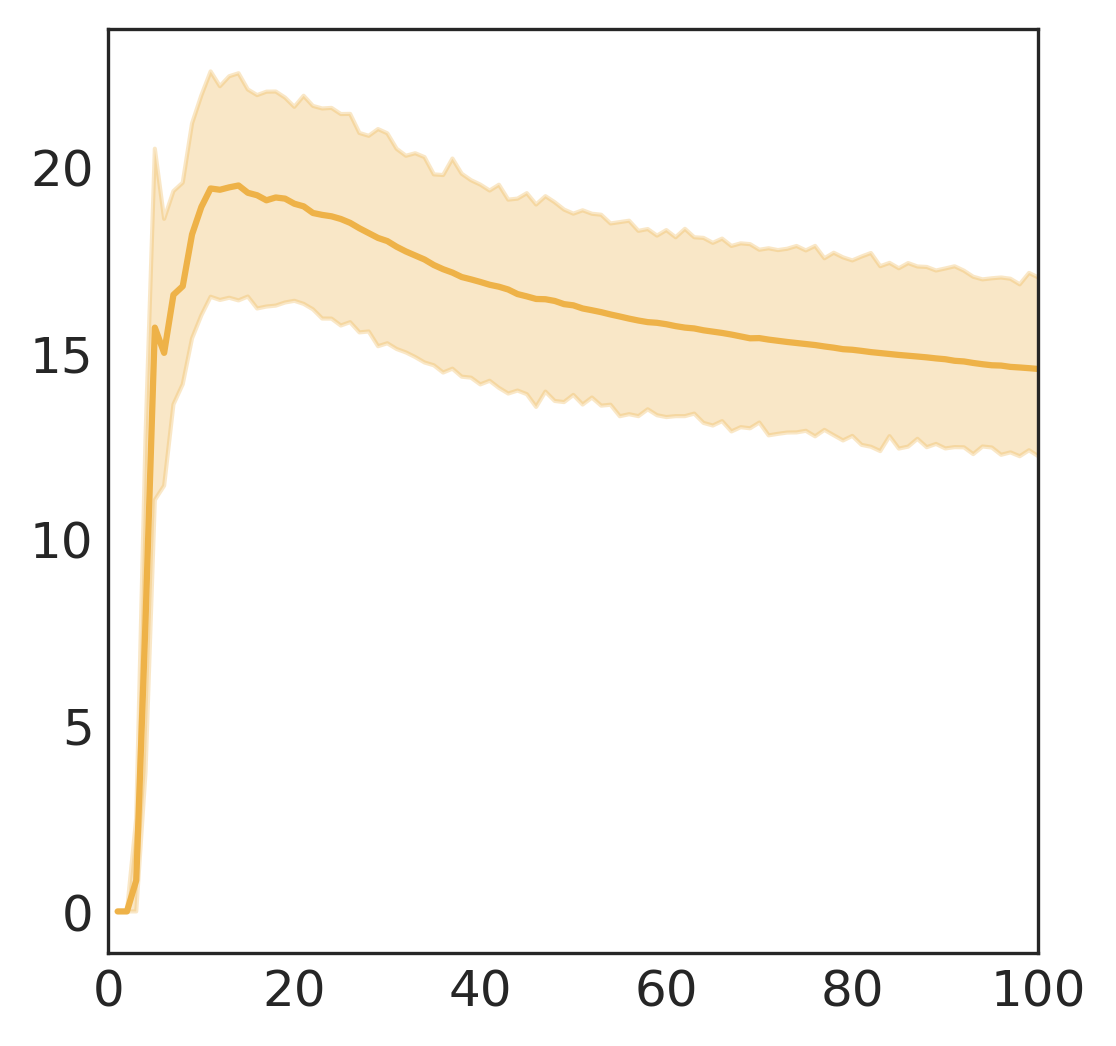

In [56]:
fig, ax = plt.subplots(figsize=(4,4), dpi = 300)

ax.plot(result['FR_PT-Fib']['radius'], result['FR_PT-Fib']['mean_intensity'], label='Mean Intensity', color='#eeb248',)
ax.fill_between(result['FR_PT-Fib']['radius'], result['FR_PT-Fib']['lower_bound'], result['FR_PT-Fib']['upper_bound'], color='#eeb248', alpha=0.3, label='Confidence Interval')

ax.set_xlim(0,100)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)
plt.savefig("FR_PT-Fib.pdf",bbox_inches="tight")
plt.show()

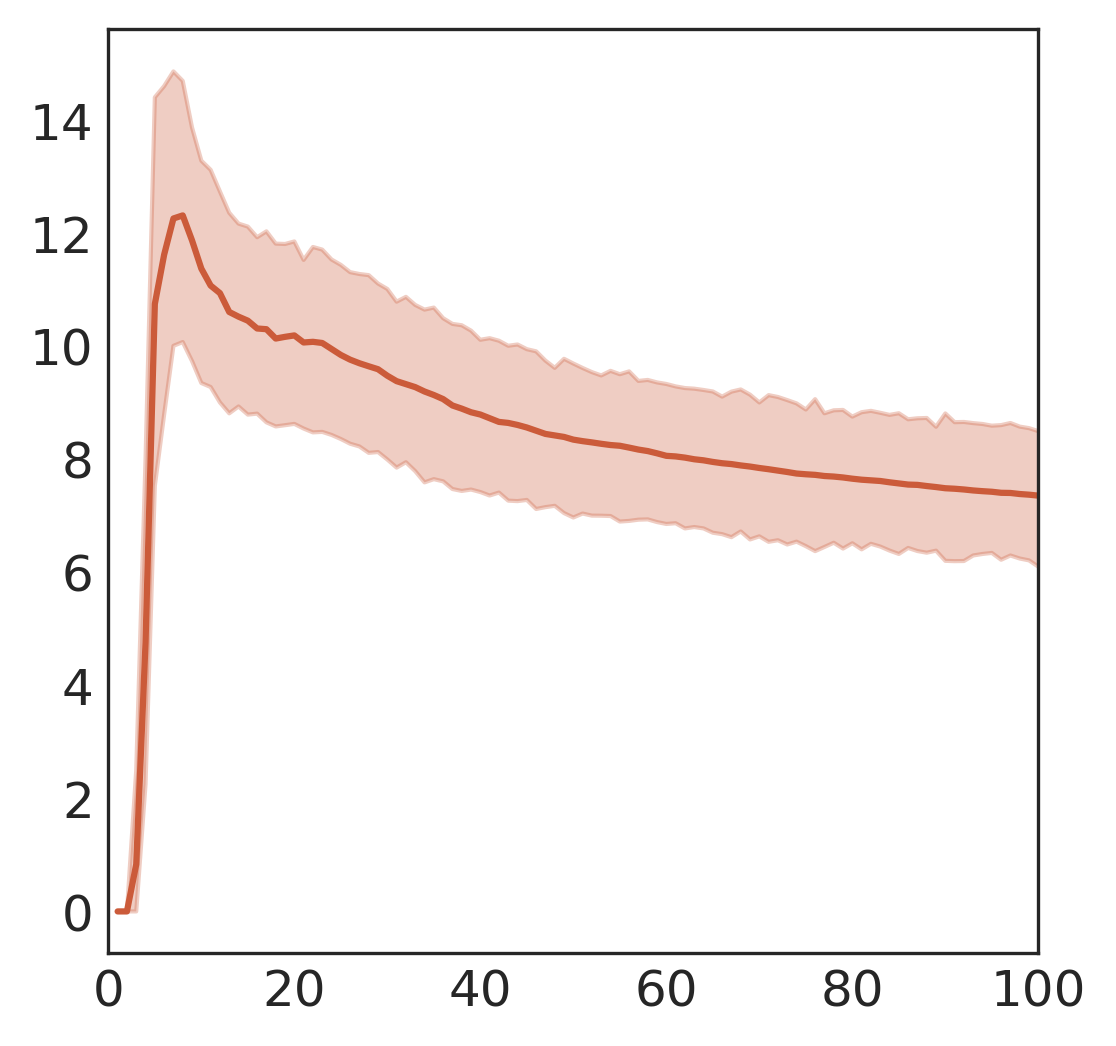

In [55]:
fig, ax = plt.subplots(figsize=(4,4), dpi = 300)

ax.plot(result['FR_PT-Immune']['radius'], result['FR_PT-Immune']['mean_intensity'], label='Mean Intensity', color='#cb5b3a')
ax.fill_between(result['FR_PT-Immune']['radius'], result['FR_PT-Immune']['lower_bound'], result['FR_PT-Immune']['upper_bound'], color='#cb5b3a', alpha=0.3, label='Confidence Interval')

ax.set_xlim(0,100)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)
plt.savefig("FR_PT-Immune.pdf",bbox_inches="tight")
plt.show()

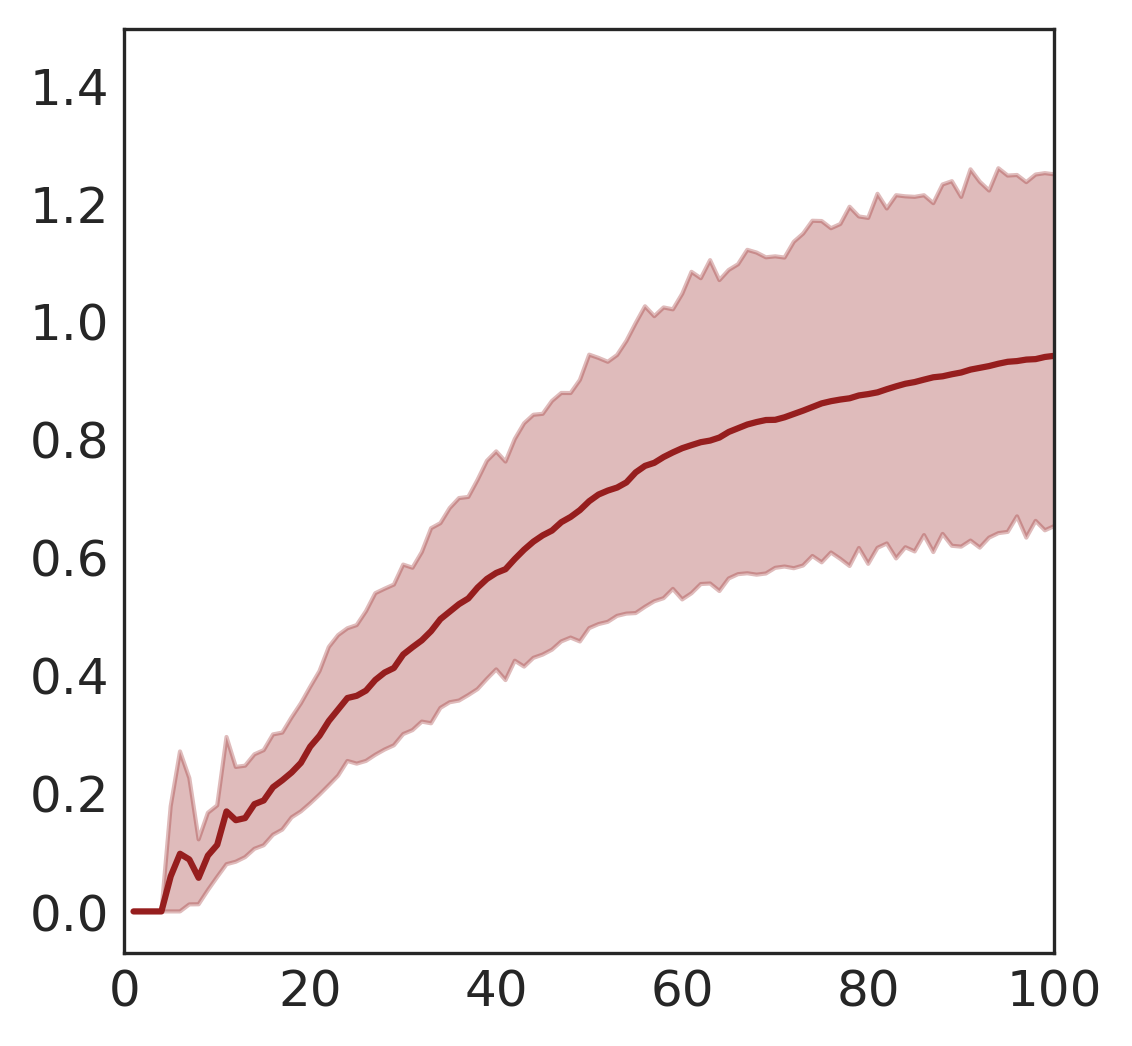

In [54]:
fig, ax = plt.subplots(figsize=(4,4), dpi = 300)

ax.plot(result['FR_PT-Pod']['radius'], result['FR_PT-Pod']['mean_intensity'], label='Mean Intensity', color='#961E1E')
ax.fill_between(result['FR_PT-Pod']['radius'], result['FR_PT-Pod']['lower_bound'], result['FR_PT-Pod']['upper_bound'], color='#961E1E', alpha=0.3, label='Confidence Interval')

ax.set_xlim(0,100)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)
plt.savefig("FR_PT-Pod.pdf",bbox_inches="tight")
plt.show()

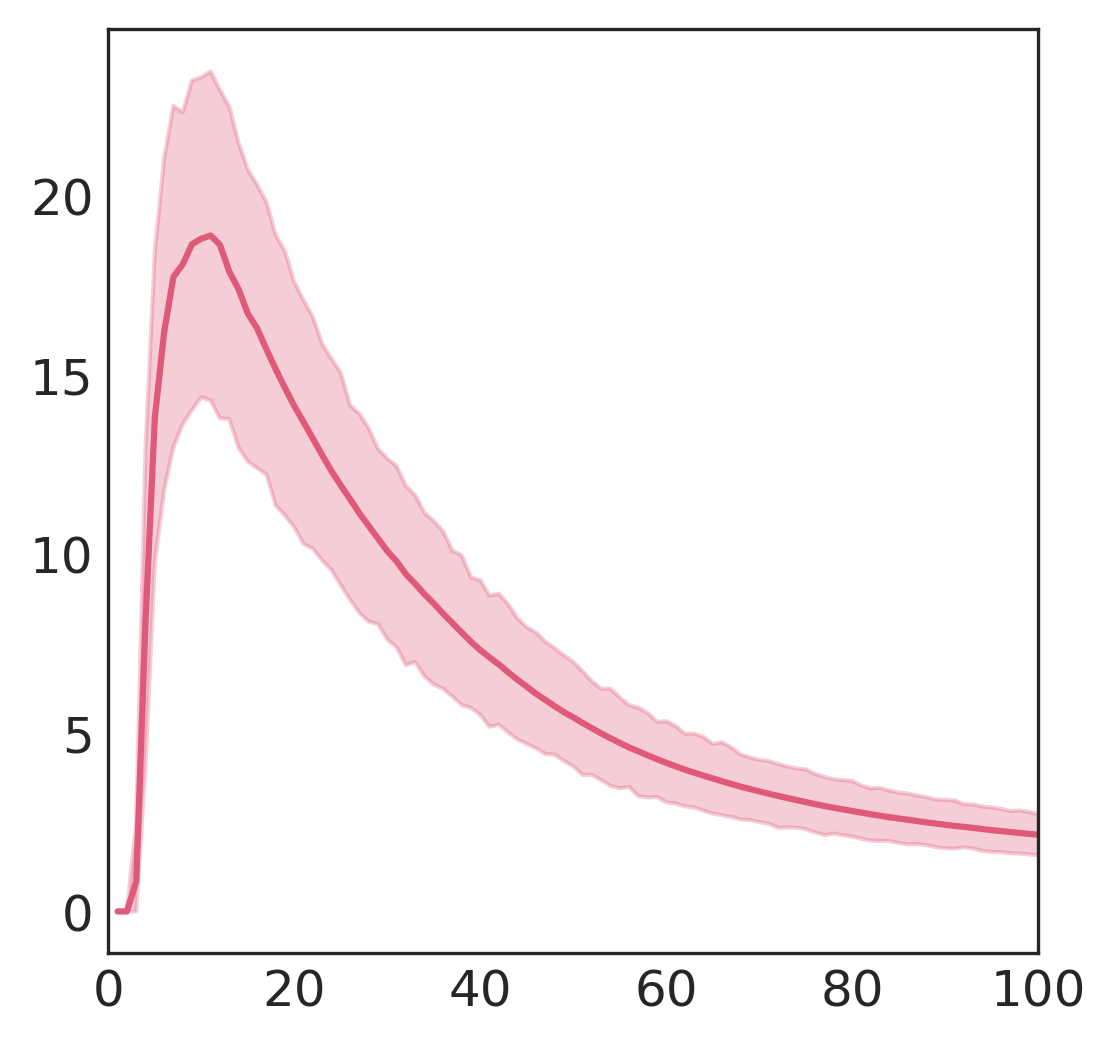

In [53]:
fig, ax = plt.subplots(figsize=(4,4), dpi = 300)

ax.plot(result['Glom_EC-Pod']['radius'], result['Glom_EC-Pod']['mean_intensity'], label='Mean Intensity', color='#df5a78')
ax.fill_between(result['Glom_EC-Pod']['radius'], result['Glom_EC-Pod']['lower_bound'], result['Glom_EC-Pod']['upper_bound'], color='#df5a78', alpha=0.3, label='Confidence Interval')

ax.set_xlim(0,100)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)
plt.savefig("Glom_EC-Pod.pdf",bbox_inches="tight")
plt.show()